<a href="https://colab.research.google.com/github/David-Gentil/Clustering/blob/main/Clustering_RFV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Crie um modelo de análise das métricas RFV
### Elabore um modelo de Clustering

> Você deverá utilizar um modelo de Clustering para criar um sistema de agrupamento de perfis de clientes para um e-commerce. Deverá analisar o modelo mais eficiente, capaz de tornar as análises mais simplificadas para a empresa.

## Contexto

Você foi contratado por uma empresa de e-commerce que está buscando entender melhor o comportamento de seus clientes para personalizar as suas campanhas de marketing. Para isso, a empresa disponibilizou uma base de dados em csv contendo dados sobre clientes, produtos e transações da loja realizadas entre os anos de 2010 e 2011.

Com base nesses dados, você precisa agrupar os clientes em clusters com base em seu comportamento de compra. Isso irá permitir identificar padrões e características em comum entre os clientes, como:

- Clientes que compram os mesmos produtos;
- Clientes que possuem a mesma frequência de compras;
- Clientes que gastam mais dinheiro em suas compras.

A partir desses clusters, gere insights para que a empresa possa segmentar melhor a sua base de clientes e personalizar as suas campanhas de marketing, direcionando promoções e ofertas aos clientes com base no comportamento de compras.

# Etapa 01) Análise exploratória dos dados

## Carregando as bibliotecas e base de dados

In [ ]:
# Instalação e importação de bibliotecas
%%capture
%pip install sidetable

import numpy as np
import pandas as pd
import sidetable

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, scale

from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from yellowbrick.cluster import kelbow_visualizer

In [ ]:
# Montando drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Carregando a base de dados
dados = pd.read_csv("/content/drive/MyDrive/RID187211_Módulo_07/data.csv", encoding='latin-1')
dados.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Data understanding

In [ ]:
# Verificando informações sobre base de dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Notamos que:

* Temos alguns dados nulos nas colunas 'Description' e 'CustomerID';
* A coluna 'InvoiceNo' está definida como object.

In [ ]:
#Verificando os dados da coluna "InvoiceNo"
dados.InvoiceNo.sort_values()

,InvoiceNo
0,536365
1,536365
2,536365
3,536365
4,536365
...,...
540449,C581490
541541,C581499
541715,C581568
541716,C581569


Verificamos que existem algumas descrições da coluna com letras e números o que justifica ser do tipo object

In [ ]:
# Verificando dados das colunas "Description" e "Country" de forma a justificar a sua relavância para o dataset
dados[['Description','Country']].nunique()

,0
Description,4223
Country,38


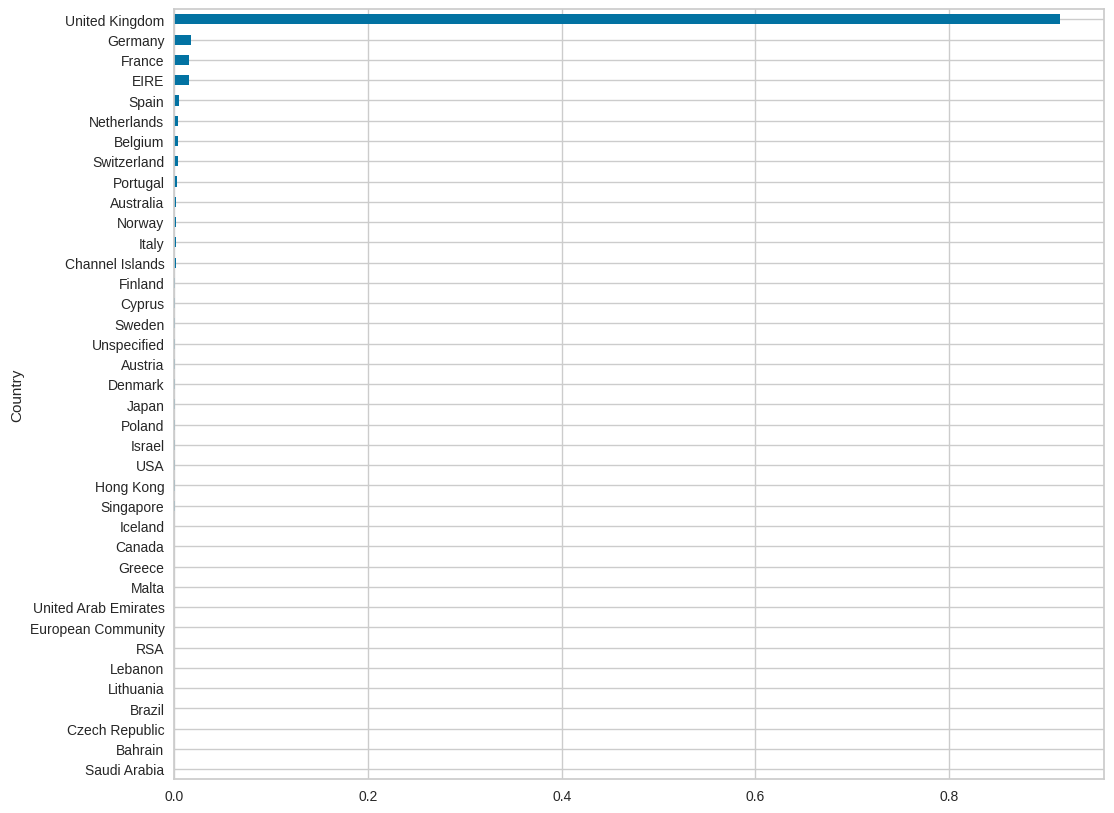

In [ ]:
#Plotando os dados da coluna "Country" para identificar a distribuição
dados['Country'].value_counts(normalize=True, ascending=True).plot.barh(figsize=(12,10));

In [ ]:
# Aplicando Side table para verificar como estão relacionados os dados da coluna "Country"
dados.stb.freq(['Country'])

,Country,count,percent,cumulative_count,cumulative_percent
0,United Kingdom,495478,91.431956,495478,91.431956
1,Germany,9495,1.752139,504973,93.184095
2,France,8557,1.579047,513530,94.763143
3,EIRE,8196,1.512431,521726,96.275574
4,Spain,2533,0.467422,524259,96.742996
5,Netherlands,2371,0.437527,526630,97.180523
6,Belgium,2069,0.381798,528699,97.562321
7,Switzerland,2002,0.369435,530701,97.931756
8,Portugal,1519,0.280305,532220,98.212061
9,Australia,1259,0.232327,533479,98.444388


In [ ]:
# Verificando a descrição dos dados da coluna "Quantity" e "UnitPrice"
dados[['Quantity','UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Verificamos que existem valores negativos para essas colunas, o que não faz sentido. Provalvelmente, esses dados forma imputados de forma errada.

In [ ]:
# Verificando quantidade de dados faltantes por coluna e ordem decrescente
dados.isna().sum().sort_values(ascending=False)

,0
CustomerID,135080
Description,1454
StockCode,0
InvoiceNo,0
Quantity,0
InvoiceDate,0
UnitPrice,0
Country,0


In [ ]:
# Verificando quantidade de dados duplicados
dados.duplicated().sum()

np.int64(5268)

In [ ]:
# Utilizando o side table para identificar os percentuais relativos dos dados faltantes nas colunas
dados.stb.missing()

,missing,total,percent
CustomerID,135080,541909,24.926694
Description,1454,541909,0.268311
StockCode,0,541909,0.000000
InvoiceNo,0,541909,0.000000
Quantity,0,541909,0.000000
InvoiceDate,0,541909,0.000000
UnitPrice,0,541909,0.000000
Country,0,541909,0.000000


# Etapa 02) Pré-processamento dos dados

## Data Cleaning

In [ ]:
# Eliminando dados faltantes da coluna "CustomerID"
dados.dropna(subset=['CustomerID'], inplace=True)

In [ ]:
# Utilizando o side table para identificar os percentuais relativos dos dados faltantes nas colunas
dados.stb.missing()

,missing,total,percent
InvoiceNo,0,406829,0.0
StockCode,0,406829,0.0
Description,0,406829,0.0
Quantity,0,406829,0.0
InvoiceDate,0,406829,0.0
UnitPrice,0,406829,0.0
CustomerID,0,406829,0.0
Country,0,406829,0.0


Identificamos que não existem mais dados faltantes na base de dados

In [ ]:
# Ajustando a coluna "InvoiceDate" para o formato de data
dados['InvoiceDate'] = pd.to_datetime(dados.InvoiceDate, format='%m/%d/%Y %H:%M')

In [ ]:
# Ajustando tipo nas colunas "CustomerID" e "Country"
dados['CustomerID'] = dados['CustomerID'].astype(int)
dados['Country'] = dados['Country'].astype('category')

In [ ]:
# Verificando as informações após os ajustes realizados
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 25.2+ MB


In [ ]:
# Definindo data inicial e final do data set
dados.InvoiceDate.agg(['min','max'])

,InvoiceDate
min,2010-12-01 08:26:00
max,2011-12-09 12:50:00


In [ ]:
# Eliminando dados das colunas'Quantity' e 'UnitPrice' que estão abaixo de zero
below0 = dados[['Quantity','UnitPrice']].le(0).any(axis=1)
dados = dados[~below0]

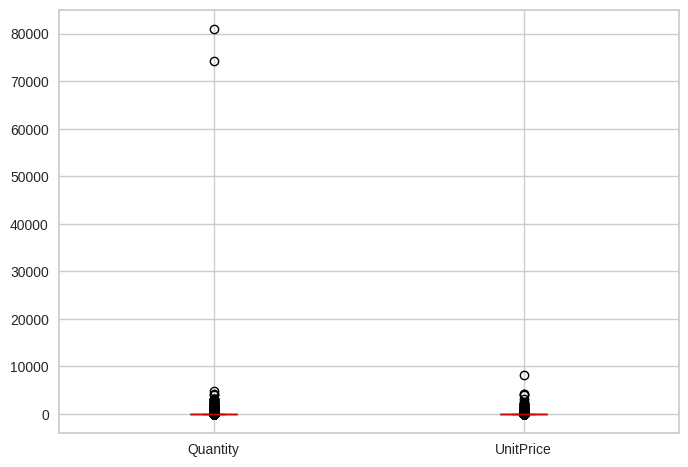

In [ ]:
# Plotando boxplot das colunas tratadas
dados[['Quantity','UnitPrice']].plot.box();

Notamos que existem outliers nas colunas plotadas, portanto precisamos realizar o tratamento.

In [ ]:
#Verificando dados que a quantidade está acima de 10000
dados.query('Quantity>10_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


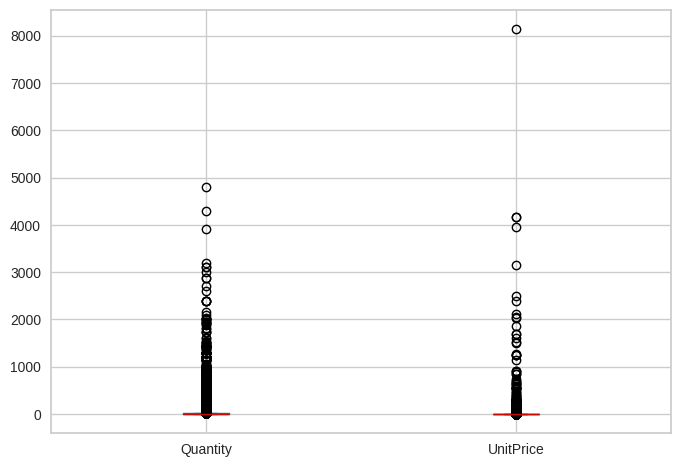

In [ ]:
#Plotando dados abaixo de 10000
dados.query('Quantity<10_000')[['Quantity','UnitPrice']].plot.box();

Notamos que ainda temos outlier na coluna "UnitPrice", portanto vamos identificar e resolver esse caso

In [ ]:
#Verficando dados com preço acima de 8000
dados.query('UnitPrice>8_000')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom


In [ ]:
# Ajustanto base para conter apenas quantidades abaixo de 10000 e preço unitário abaixo de 8000
dados = dados.query('Quantity<10_000 & UnitPrice<8_000')

In [ ]:
# Criando coluna de preço Total
dados['price_total'] = dados.Quantity * dados.UnitPrice
dados

<ipython-input-26-c1024157bc2d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['price_total'] = dados.Quantity * dados.UnitPrice


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60


## Métricas RFV

In [ ]:
# Definindo a data atual
data_atual = pd.Timestamp.today()

In [ ]:
#Agrupando dados pela coluna "CustomerID" e definindo o RFV
dados_rfv = (
  dados.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (data_atual - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      V = ('price_total', 'mean')
  )
)

dados_rfv

,R,F,V
CustomerID,,,
12347,4883,7,23.681319
12348,4956,4,57.975484
12349,4899,1,24.076027
12350,5191,1,19.670588
12352,4917,8,29.482824
...,...,...,...
18280,5158,1,18.060000
18281,5061,1,11.545714
18282,4888,2,14.837500


Notamos que a Recência deu muito alta, em função de ser um dataset mais antigo. Para ajustar e termos dados mais próximos de uma realidade, vamos adotar a data atual como sendo 2012-01-01.

In [ ]:
#Agrupando dados pela coluna "CustomerID" e definindo o RFV
data_atual = pd.Timestamp('2012-01-01') #substituindo data atual por '2012-01-01'
dados_rfv = (
  dados.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (data_atual - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      V = ('price_total', 'mean')
  )
)

dados_rfv

,R,F,V
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824
...,...,...,...
18280,299,1,18.060000
18281,202,1,11.545714
18282,29,2,14.837500


Vimos que a escala dos dados estão muito distantes, portanto iremos realizar as plotagens ajustando a escala para melhor análise

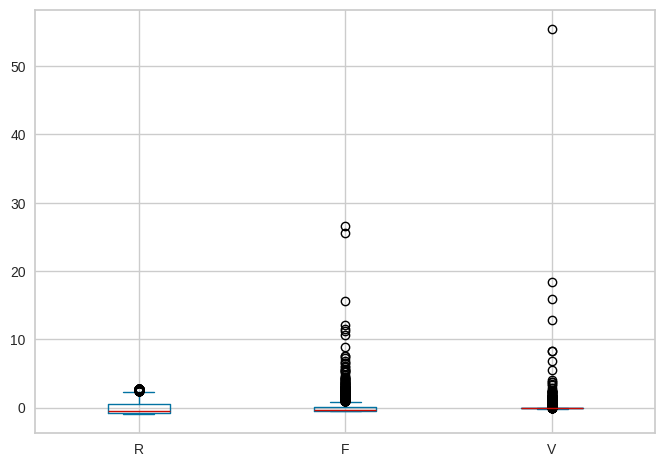

In [ ]:
# Plotando boxplot do RFM com escala ajustada
dados_rfv.apply(scale).plot.box();

In [ ]:
# Idetificando os dados de V>50
dados_rfv.apply(scale).query('V>50')

,R,F,V
CustomerID,,,
15098,0.899878,-0.165317,55.434876


Identificamos que esses dados pertencem apenas ao "CustomerID" == 15098

In [ ]:
# Identificando os dados do "CustomerID" == 15098
dados.query('CustomerID==15098')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,price_total
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


In [ ]:
# Eliminando os dados do "CustomerID" == 15098 do modelo, visto que é uma quantidade insignificante para o modelo
dados_rfv = dados_rfv.drop(15098)

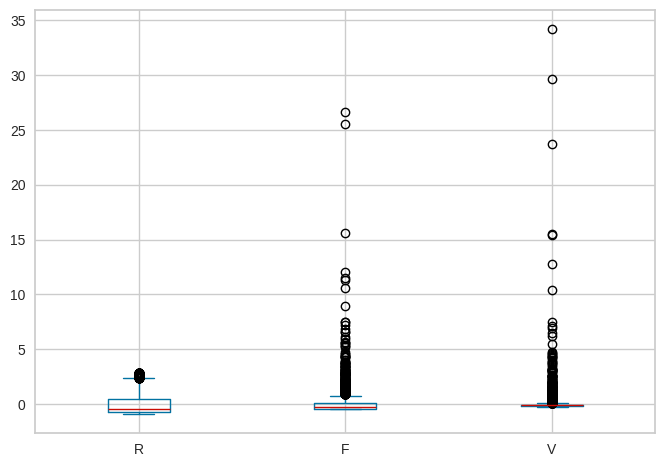

In [ ]:
# Plotando dados ajustados
dados_rfv.apply(scale).plot.box();

In [ ]:
# Aplicando o PowerTransformer para alterar vetores em uma representação mais adequada
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer()
dados_rfv_scaled = pd.DataFrame(scaler.fit_transform(dados_rfv), index=dados_rfv.index, columns=dados_rfv.columns)
dados_rfv_scaled

,R,F,V
CustomerID,,,
12347,-1.563219,1.201866,0.407836
12348,0.323470,0.660670,1.329304
12349,-0.809134,-1.158070,0.426829
12350,1.568467,-1.158070,0.189376
12352,-0.307718,1.309671,0.653411
...,...,...,...
18280,1.475652,-1.158070,0.085562
18281,1.107356,-1.158070,-0.491003
18282,-1.275046,-0.195707,-0.161007


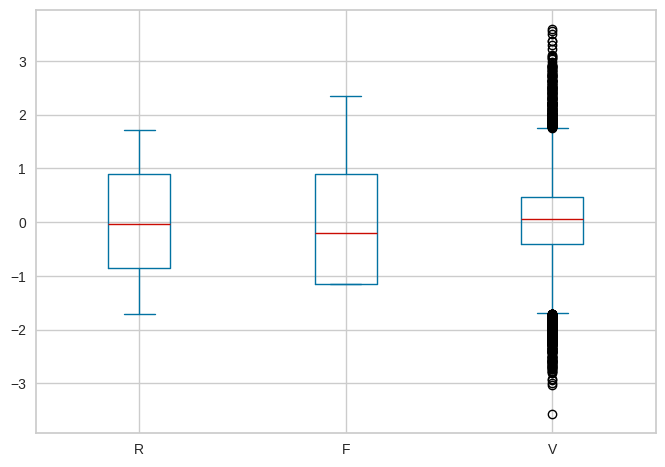

In [ ]:
# Plotando os dados transformados
dados_rfv_scaled.plot.box();

Notamos que ainda exitem alguns outliers, portanto vamos criar um dataset com a premissa que os valores máximos estejam entre os 95% dos valores aceitáveis.

In [ ]:
# Definindo valores máximos para que eles estejam entre os 95% dos valores
dados_rfv_clip = dados_rfv.apply(lambda x: x.clip(upper=x.quantile(.95)))
dados_rfv_clip.describe()

,R,F,V
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608164,23.634656
std,95.504576,3.358999,20.993635
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.339095
50%,72.000000,2.000000,17.715999
75%,163.250000,5.000000,24.843993
max,333.000000,13.000000,91.768421


In [ ]:
# Aplicar escala no novo dataset
dados_rfv_clip_scaled = dados_rfv_clip.apply(scale)

# Etapa 03) Selecione um algoritmo de clusterização

Para essa etapa vamos modelar com K-Means, Hierarchical Clustering, DBSCAN, Mean Shift e Gaussian Mixture, e avaliar o modelo que melhor performou para definir qual iremos implementar

## K-Means

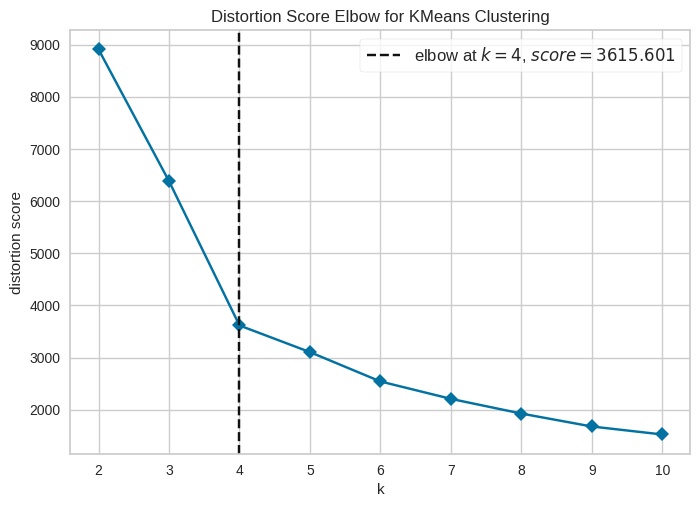

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10), timings=False)

In [ ]:
# Plotando o Elbow para definir a quantidade ideal de clusters
kelbow_visualizer(KMeans(), dados_rfv_clip_scaled, k=10, timings=False)

In [ ]:
# Criando uma lista de dicionários

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = dados_rfv_clip_scaled

for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,9608.319042,0.481575,1.042550,1533.485432
3,6380.827963,0.395222,0.918987,2250.147145
4,3615.611638,0.479553,0.704462,3751.144746
5,3104.989759,0.386168,0.855067,3453.313624
6,2542.521220,0.397775,0.851237,3564.616053
7,2240.392476,0.401925,0.849436,3467.623360
8,1907.087195,0.383633,0.862005,3598.989252
9,1668.788329,0.394132,0.800834,3675.183274
10,1516.652722,0.351693,0.887890,3641.928356


Notamos que o silhouette_score e o calinski_harabasz_score, confirmaram o que vimos no método de Elbow, ou seja, que o número ideal de clusters para esse dataset é 4.

In [ ]:
# Plotando gráfico 3D dos clusters
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(dados_rfv_clip_scaled)
labels_formatados = ['Cluster ' + str(i) for i in kmeans_labels + 1]
px.scatter_3d(dados_rfv_clip, x='R', y='F', z='V', color=labels_formatados, template='plotly_dark')

## Hierarchical Clustering

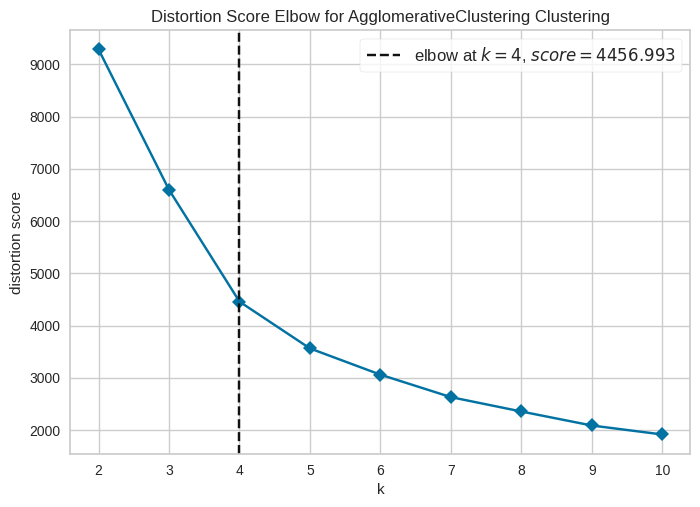

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=AgglomerativeClustering(n_clusters=10),
                 timings=False)

In [ ]:
# Plotando o Elbow para definir a quantidade ideal de clusters
kelbow_visualizer(AgglomerativeClustering(), dados_rfv_clip_scaled, k=10, timings=False)

In [ ]:
# Criando uma lista de dicionários

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []
X = dados_rfv_clip_scaled

for k in range(2,11):
  model = AgglomerativeClustering(n_clusters=k)
  labels = model.fit_predict(X)
  cluster_results_dict = {'k': k}
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(X, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,
2,0.361292,1.331666,1737.623791
3,0.398928,0.869855,2104.783905
4,0.431886,0.761966,2770.399918
5,0.342136,0.897329,2872.239315
6,0.348298,0.791909,2816.854970
7,0.322680,0.844326,2848.491623
8,0.287643,0.967432,2799.001327
9,0.286883,0.976982,2832.797336
10,0.298923,0.953087,2786.657350


In [ ]:
# Plotando gráfico 3D dos clusters
hclust = AgglomerativeClustering(n_clusters=4)
hclust_labels = hclust.fit_predict(dados_rfv_clip_scaled)
labels_formatados = ['Cluster ' + str(i) for i in hclust_labels + 1]
px.scatter_3d(dados_rfv_clip, x='R', y='F', z='V', color=labels_formatados, template='plotly_dark')

## DBSCAN

In [ ]:
# DBSCAN não usa "k", mas sim eps e min_samples.
X = dados_rfv_clip_scaled
dbscan = DBSCAN(eps=0.8, min_samples=3)
labels_dbscan = dbscan.fit_predict(X)

# Verificando o número de clusters identificados
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"Número de clusters identificados pelo DBSCAN: {n_clusters_dbscan}")

Número de clusters identificados pelo DBSCAN: 1


In [ ]:
# Como houve apenas um cluster, ajustaremos os parâmetros do DBSCAN
if n_clusters_dbscan <= 1:
    print("Ajustando parâmetros do DBSCAN...")
    # Experimente diferentes valores para eps e min_samples
    dbscan = DBSCAN(eps=0.8, min_samples=2)  # Exemplo de ajuste
    labels_dbscan = dbscan.fit_predict(X)
    n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
    print(f"Novo número de clusters: {n_clusters_dbscan}")

Ajustando parâmetros do DBSCAN...
Novo número de clusters: 2


In [ ]:
# Filtrando ruído (label = -1) para métricas
mask = labels_dbscan != -1
X_filtered = X[mask]
labels_filtered = labels_dbscan[mask]

In [ ]:
# Avaliando as métricas
dbscan_results = {
    'silhouette_score': silhouette_score(X_filtered, labels_filtered),
    'davies_bouldin_score': davies_bouldin_score(X_filtered, labels_filtered),
    'calinski_harabasz_score': calinski_harabasz_score(X_filtered, labels_filtered),
    'n_clusters': len(set(labels_filtered))
}

print(pd.DataFrame([dbscan_results]))

   silhouette_score  davies_bouldin_score  calinski_harabasz_score  n_clusters
0          0.307631              0.607705                 4.644009           2


In [ ]:
# Visualização 3D

labels_formatados = ['Cluster ' + str(int(i) + 1) if str(i).isdigit() else 'Ruído' for i in labels_dbscan]
px.scatter_3d(dados_rfv_clip, x='R', y='F', z='V',
              color=labels_formatados,
              template='plotly_dark').show()

## Mean Shift

In [ ]:
# Definindo variável X
X = dados_rfv_clip_scaled

# Estimando a largura de banda (bandwidth) automaticamente
from sklearn.cluster import estimate_bandwidth
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels_meanshift = meanshift.fit_predict(X)

In [ ]:
# Avaliação das métricas
meanshift_results = {
    'silhouette_score': silhouette_score(X, labels_meanshift),
    'davies_bouldin_score': davies_bouldin_score(X, labels_meanshift),
    'calinski_harabasz_score': calinski_harabasz_score(X, labels_meanshift),
    'n_clusters': len(set(labels_meanshift))
}

print(pd.DataFrame([meanshift_results]))

   silhouette_score  davies_bouldin_score  calinski_harabasz_score  n_clusters
0          0.439287              0.772946              2338.087726           6


In [ ]:
# Visualização 3D
labels_formatados = ['Cluster ' + str(i) for i in labels_meanshift + 1]
px.scatter_3d(dados_rfv_clip, x='R', y='F', z='V',
              color=labels_formatados,
              template='plotly_dark').show()

## Gaussian Mixture

In [ ]:
# Selecionano o melhor modelo por tipo de covariância e k (Practical Statistics for Data Scientists)
results = []
k_range = range(1,9)
covariance_types = ['full', 'tied', 'diag', 'spherical']
X = dados_rfv_clip_scaled

for n_components in k_range:
  for covariance_type in covariance_types:
    mclust = GaussianMixture(n_components=n_components, n_init=10, warm_start=True, covariance_type=covariance_type)
    mclust.fit(X)
    results.append({
      'bic': mclust.bic(X),
      'n_components': n_components,
      'covariance_type': covariance_type,
    })

results = pd.DataFrame(results)
results.sort_values('bic').head()

,bic,n_components,covariance_type
28,-8.913689,8,full
26,211.671011,7,diag
24,220.213439,7,full
30,6714.291673,8,diag
22,8985.098070,6,diag


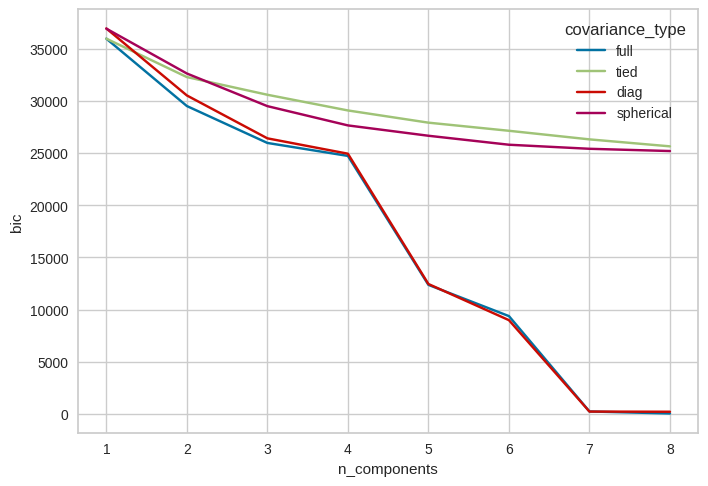

In [ ]:
# Plotando gráfico que mostra a relação entre o número de componentes (n_components) e o critério de informação de Bayes (BIC),
# com a cor da linha a indicar o tipo de covariância (covariance_type)
sns.lineplot(data=results, x='n_components', y='bic', hue='covariance_type');

In [ ]:
# Plotando gráfico 3D dos clusters
mclust = GaussianMixture(n_components=7, covariance_type='full', n_init=10)
mclust_labels = mclust.fit_predict(dados_rfv_clip_scaled)
labels_formatados = ['Cluster ' + str(i) for i in mclust_labels + 1]
px.scatter_3d(dados_rfv_clip, x='R', y='F', z='V', color=labels_formatados, template='plotly_dark')

## Avaliação dos modelos:

* Vimos que o os modelos criados com o Kmeans e Hierarchical Clustering performaram melhor considerando as métricas, principalmente o Silhouette Score.
* Além disso, o número de clusters (4) faz bastante sentido para o caso de estudo qeu temos aqui, pois queremos determinar perfis dos clientes, sendo entre 3 a 5 clusters, um conjunto adequado para análise.

Para prosseguirmos, iremos utilizar o metódo do Kmeans.

# Etapa 04) Analise os clusters obtidos

## Identificando os padrões e características em comum entre os clientes

Para identificar os padrões, devemos examinar as características com relação a R, F, e V.

* Recência (R):

Mede o tempo desde a última compra de um cliente até uma data de referência (normalmente a data atual).

Quanto menor o valor, mais recente foi a compra.

Clientes com recência baixa são mais propensos a responder a campanhas de marketing, pois estão “ativos”.

* Frequência (F):
Quantas vezes o cliente comprou em um período específico.

Mede a frequência de compras.

Clientes com alta frequência geralmente são fiéis e têm maior envolvimento com a marca.

* Valor (V):
Quanto o cliente gastou no total.

Representa o valor monetário total gasto pelo cliente no período analisado.

Ajuda a identificar os clientes mais lucrativos.

## Plotando gráficos para auxiliar na análise

In [ ]:
# Plotando gráfico 3D dos clusters
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(dados_rfv_clip_scaled)
labels_formatados = ['Cluster ' + str(i) for i in kmeans_labels + 1]
px.scatter_3d(dados_rfv_clip, x='R', y='F', z='V', color=labels_formatados, template='plotly_dark')

In [ ]:
# criando um DataFrame com as coordenadas dos centróides dos clusters gerados pelo modelo KMeans
centers = pd.DataFrame(kmeans.cluster_centers_, columns=dados_rfv_clip_scaled.columns)

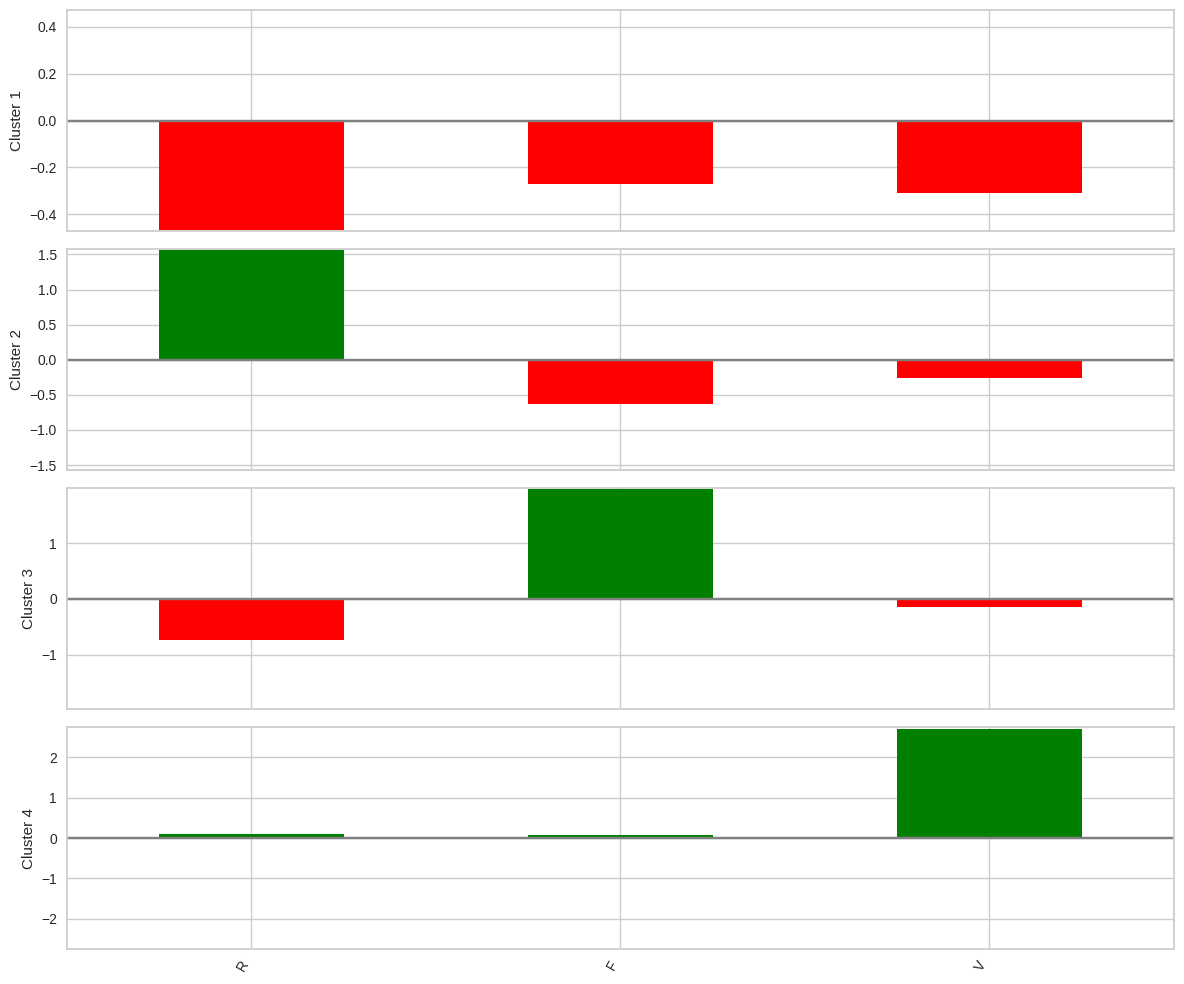

In [ ]:
# Plotando um gráfico de barras separado para cada cluster, mostrando visualmente os valores dos centróides por variável
fig,axes = plt.subplots(nrows=4, figsize=(12,10), sharex=True)

for i,ax in enumerate(axes):
  center = centers.loc[i,:]
  maxPC = 1.01 * center.abs().max()
  colors = ['green' if l > 0 else 'red' for l in center]
  center.plot.bar(ax=ax, color=colors)
  ax.set_ylabel(f'Cluster {i+1}')
  ax.set_ylim(-maxPC, maxPC)
  ax.axhline(color='gray')
  ax.xaxis.set_ticks_position('none')

plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# analisando o perfil médio de cada cluster baseado nos valores originais de R, F e V (antes do scaling)
(dados_rfv_clip.assign(cluster=kmeans_labels)
  .groupby('cluster')
  .mean()
  .transpose()
  .style.background_gradient(cmap='YlOrRd', axis=1))

cluster,0,1,2,3
R,67.523221,261.082051,41.517018,121.057935
F,2.703877,1.509744,10.191248,3.876574
V,17.120301,18.104189,20.426973,80.714098


# Etapa 05) Interpretação dos resultados obtidos

## Descrição do perfil de compras dos clientes de cada cluster

* Cluster 1: Clientes com Baixa Recência, Frequência e valor: Pode indicar clientes que compraram recentemente, mas não com muita frequência e não gastaram muito por vez;

* Cluster 2: Clientescom Alta Recência, porém com Baixa Frequência e valor: Pode indicar clientes "Churn", ou seja, clientes ou assinantes que deixaram de consumir os produtos da empresa;

* Cluster 3: Clientes com Baixa Recência e valor, porém Alta Frequência: Pode representar clientes fidelizados, que compram com regularidade, mas gastam pouco por vez.

* Cluster 4: Clientes com Baixa Recência, frequência e Alto Valor: Pode indicar clientes que compraram recentemente, mas não com muita frequência, mas gastaram muito por vez;

## Justificativa para a análise

###Segmentação Inteligente e Baseada em Dados

A análise de clusters permite dividir a base de clientes em grupos com comportamentos semelhantes, o que é muito mais eficaz do que tratar todos os clientes de forma genérica. Isso cria uma visão clara de quem são os clientes valiosos, os fiéis, os inativos e os potenciais churns.

### Personalização de Campanhas de Marketing

Cada cluster exige uma abordagem personalizada, aumentando drasticamente a taxa de conversão das campanhas. A empresa deixa de gastar energia e orçamento em ações amplas e passa a falar a linguagem de cada grupo.

### Otimização de Investimentos em Marketing e CRM

A empresa consegue investir recursos de marketing de forma mais eficiente, priorizando os grupos com maior potencial de retorno, enquanto reduz esforços com perfis de baixo engajamento ou rentabilidade.

### Resultado Esperado:

* Aumento na conversão das campanhas.

* Maior retenção de clientes valiosos.

* Melhor ROI em marketing.

* Decisões estratégicas embasadas em dados concretos.

## Ações Sugeridas

Com base na análise de clusters RFV realizada, seguem ações táticas e estratégicas específicas para cada Cluster, visando maximizar engajamento, retenção e rentabilidade.

### Cluster 1 — Baixa Recência, Baixa Frequência, Baixo Valor

Perfil: Clientes recentes, mas pouco engajados e pouco rentáveis.
Ações sugeridas:

* Campanhas de educação sobre produtos/benefícios (ex: onboarding automatizado).

* Ofertas de baixo custo ou frete grátis para estimular uma nova compra.

* Teste A/B de gatilhos de recompra rápida (ex: “Compre novamente e ganhe um brinde”).

### Cluster 2 — Alta Recência, Baixa Frequência, Baixo Valor

Perfil: Clientes que compraram há muito tempo e não voltaram — churn provável.
Ações sugeridas:

* Campanhas de recuperação agressivas, com cupons personalizados.

* E-mails com pesquisas de satisfação ou abandono ("Por que você parou de comprar?").

* Remarketing digital com produtos visualizados anteriormente.

### Cluster 3 — Baixa Recência, Alta Frequência, Baixo Valor

Perfil: Clientes fiéis, porém com ticket médio baixo.
Ações sugeridas:

* Cross-sell e upsell com produtos complementares.

* Programas de fidelidade ou cashback progressivo.

* Recomendações personalizadas com base no histórico de compras.

### Cluster 4 — Baixa Recência, Baixa Frequência, Alto Valor

Perfil: Compradores recentes e valiosos, mas com baixa frequência.
Ações sugeridas:

* Assinaturas ou planos VIP com vantagens exclusivas.

* Ofertas personalizadas de produtos premium ou limitados.

* Contato direto (e-mail premium, ligação, concierge) oferecendo atendimento diferenciado.

### Ações Transversais (para todos os clusters)

* Implementar painel de monitoramento RFV para acompanhar evolução dos grupos.

* Automatizar ações com ferramentas de marketing automation baseadas em comportamento.

* Realizar testes contínuos por cluster (ex: canal preferido, horário de envio, tipo de oferta).